## Astronomy 406 "Computational Astrophysics" (Fall 2015)

### Week 2: Interpolation and Numerical Derivatives

<b>Reading:</b> notes below, as well as $\S$[3.0-3.6](https://umich.instructure.com/files/2342968/download?download_frd=1) and $\S$[5.7](https://umich.instructure.com/files/2392548/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes).

#### Interpolation of tabulated data

All data available to us are presented in a tabulated form. Even when we look at a line on a plot of $y$ vs. $x$, it is not a continuous function but a set of discrete data points (an array of values $x_i$ and $y_i$, for $i=0, N$, in computer representation).

Sometimes it is desirable to know the expected value of $y$ at a point between the tabulated $x_i$.  Such an expectation function is called interpolating function, and the process is called interpolation.

Let's look at an example. Remember to execute each cell.  First, set up the necessary libraries.

In [5]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

Now let's create a simple dataset and plot it.

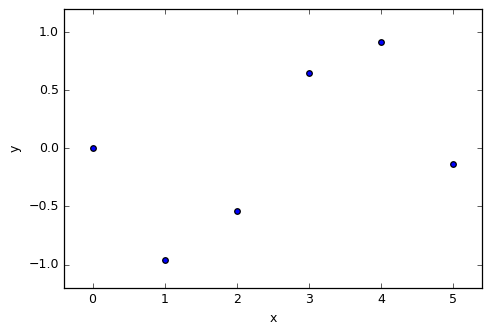

In [2]:
x = np.array([0, 1, 2, 3, 4, 5])
y = np.sin(5.*x)

plt.xlim(-0.4, 5.4)
plt.ylim(-1.2, 1.2)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y)
plt.show()

Is there a unique way to connect the points? Your eye may guide you to a smooth curve going up and down, for example using straight lines.  Let's plot it below.

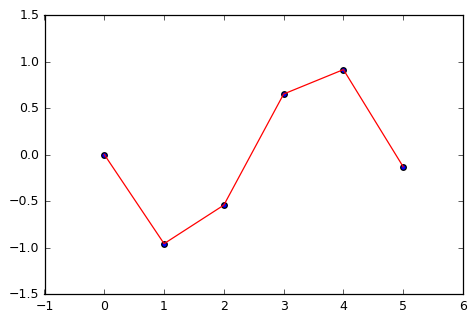

In [3]:
plt.plot(x, y, 'r-')
plt.scatter(x, y)

Now let's plot the real function used to generate these points.

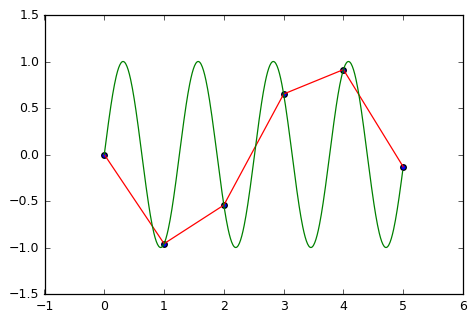

In [4]:
plt.scatter(x, y)
plt.plot(x, y, 'r-')

# overplot the generating function
xa = np.arange(0, 5, 0.01)
plt.plot(xa, np.sin(5.*xa), 'g-')

We can see that we missed a lot of ups and downs!  The point of this exercise is to illustrate that there is no unique way to connect discrete data points.  So, what should we do in practice?

The answer depends on what we know and what we want to achieve.  If we know absolutely nothing about the origin of our data points (how they were obtained, what they represent), then we go for straight lines as in the example above.  It is called 'linear interpolation' and is the most basic, and robust, way of estimating the value of $y$ between the data points.

However, if we know that the data represent measurements of some fairly predictable variable, which should vary smoothly with $x$, then we can use higher-order interpolation schemes.  The most common is 'spline interpolation'.

Let's use functions provided by the SciPy package.

[  1.37706218e-17  -1.14337389e+00  -1.27693877e+00   1.41585042e+00
   9.88481270e-01  -1.32351750e-01]


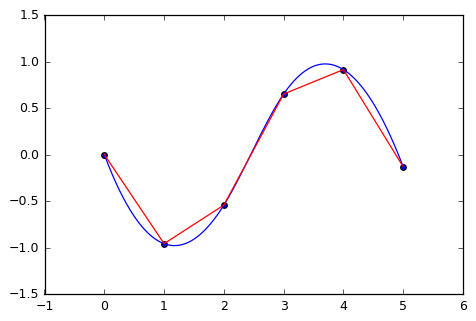

In [6]:
yint = interpolate.interp1d(x, y, kind='linear')
yspline = interpolate.UnivariateSpline(x, y, s=0)

print yspline.get_coeffs()

plt.scatter(x, y)
plt.plot(xa, yspline(xa), 'b-', label='spline')
plt.plot(xa, yint(xa), 'r-', label='linear')

The red line corresponds to the unique first-order (linear) polynomial that goes through the all data points exactly.  You can also use the third-order polynomial by switching the <t>kind</t> value to <t>cubic</t>.

The blue line corresponds to a spline function that guarantees a continuous second derivative of the interpolating function.  The idea behind splines is to add a cubic polynomial to a linear function, such that $y'' = d^2y/dx^2$ varies linearly between each neighbor pair of data points $x_i$ and $x_{i+1}$, and the first derivative $y' = dy/dx$ is continuous across the data points.  It turns out that there is an (almost) unique solution that satisfies these requirements.  Almost unique because $y''$ needs to be specified at the two end points; these are usually set to zero, enforcing linear interpolation beyond the range of available data.  It makes sense - we should never use non-linear extrapolation.

(s is a way to smooth the function - the larger s is, the larger error/deviation from our dataset we could have. Good way to reduce noise, allowing you to see broader picture more easily.)

The parameter $s$ in the UnivariateSpline function above allows a smoother fit, which passes acceptably close to the data points, but not necessarily exactly through them.  The larger $s$, the larger an acceptable deviation:
$\sum_i (y_i-\mathrm{spl}(x_i))^2 <= s$.
We will come back to this metric when we discuss fitting a model to a dataset.

The UnivariateSpline routine first calculates the fixed coefficients corresponding to the values of $y''_i$ and stores them as an array.  This completely specifies a simple (third-order in $x$) analytical function that describes our data throughout the whole interval of data.  We can then evaluate this function at as many locations as we need without having to repeat the polynomial fit, as in the interp1d routine.

An additional advantage of using spline interpolation is that we can integrate or differentiate the interpolating function analytically, and similarly evaluate $\int y(d) dx$ or $dy/dx$ at any location.  Without any extra calculation!  In fact, it is one of the most convenient ways to evaluate a derivative of a function known only at discrete points.  The UnivariateSpline routine provides the functions to do it.

Lets look at another data set, which we will use later next week.  The data file is located in 'Canvas/Files/Data files'.  Download it and place in the same folder as this Notebook.

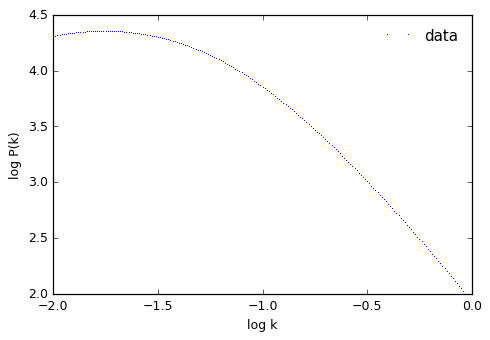

In [7]:
logk_data, logPk_data = np.loadtxt("pk2.dat", unpack=True)

plt.xlim(-2, 0)
plt.ylim(2, 4.5)
plt.xlabel('log k')
plt.ylabel('log P(k)')
plt.plot(logk_data, logPk_data, ',', label='data')
plt.legend(frameon=False)

<b>Exercise 1:</b> Create a spline interpolating function for this data set.  Evaluate $P(k)$ and $dP/dk$ it at $k = -0.47$ and $k = 0.52$.  Note that the data are provided as logarithms base-10 for both $k$ and $P(k)$.  You need to transform them accordingly.

P(-0.47) = -1.047E+10
P(0.52) = 358.723
P'(-0.47) = 6.537E+10
P'(0.52) = -1477.11


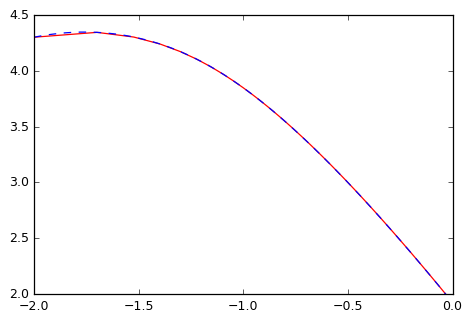

In [8]:
from scipy.misc import derivative

kData = 10.**logk_data
PkData = 10.**logPk_data

Pkspline = interpolate.UnivariateSpline(kData, PkData, s = 0, ext = 0)
PksplinePrime = Pkspline.derivative()

print 'P(-0.47) = %.3E' % Pkspline(-0.47)
print 'P(0.52) = %G' % Pkspline(0.52)

print 'P\'(-0.47) = %.3E' % PksplinePrime(-0.47)
print 'P\'(0.52) = %G' % PksplinePrime(0.52)

kNew = np.arange(kData[0], kData[-1], .01)
plt.xlim(-2, 0)
plt.ylim(2, 4.5)
plt.plot(np.log10(kNew), np.log10(Pkspline(kNew)), 'r')
plt.plot(logk_data, logPk_data, 'b--')

Interpolation can also be used to reverse functional relations.  It is a very convenient feature of the numerical method, compared to the more complicated analytical way.

#### Differentiation

Calculating a derivative may seem as a straightforward task.  Choose a small offset of the independent variable, $dx = h$, and calculate $f'(x) = {f(x+h)-f(x) \over h}$.  There many issues and pitfalls in such an approach.

There are both sources of error in this equation, truncation error and roundoff error.  The truncation error comes from the higher terms in the Taylor series expansion: 
$f(x+h) = f(x) + h f'(x) + {1\over 2}h^2 f''(x) + {1\over 6}h^3 f'''(x) + ...$, so

${f(x+h)-f(x) \over h} = f'(x) + {1\over 2}h f''(x) + ...$, and

$e_t \sim |h f''(x)|$.

The roundoff error comes mainly from the accuracy of calculation of $f(x)$: $\epsilon_r \sim \epsilon_f |f(x)/h|$, where $\epsilon_f$ is the fractional error of calculation of $f(x)$.  

The optimal choice of $h$ minimizes the sum $e_t + e_r$, which gives
$h \sim \sqrt{\epsilon_f f \over f''} \approx \sqrt{\epsilon_f} x_c$.
Here $x_c$ is the characteristic scale over which function $f(x)$ varies, which can often be taken as $x_c = x$.  With this choice of $h$, the fractional error of the derivative calculation is
$(e_r + e_t)/|f'| \sim \sqrt{\epsilon_f} \sqrt{f f''/f'^2} \sim \sqrt{\epsilon_f}$.
If a typical error of evaluting $f(x)$ is 1%, then the error of the derivative is already 10%.

<b>Exercise 2:</b> Show analytically, following a similar derivation, that a symmetric derivative $f' = {f(x+h)-f(x-h) \over 2h}$ has an optimal choice of $h \sim \epsilon_f^{1/3} x_c$ and the fractional error of $(e_r + e_t)/|f'| \sim {\epsilon_f}^{2/3}$.  This is a significantly better scaling when ${\epsilon_f} \lesssim 0.01$.

<b>Exercise 3:</b> Write a routine to calculate the derivative $dP/dk$ from Exercise 1 for a given value of $h$, and output the result for a sequence of $h = 10^{-8}, 10^{-7}, ..., 10^{-1}$.  Plot the sequence of $dP/dk$ as a function of $h$.  Estimate the optimum value of $h$ for your scheme and add it to your plot.  Does this value correspond to any feature in the plot?

In [ ]:
#given Pkspline

def PkDerivative(k, h):
    return (Pkspline(k + h) - Pkspline(k - h)) / (2. * h)

Let's take a discrete representation of a Gaussian function and interpolate it.  This will be the function that we will then differentiate (and later integrate).

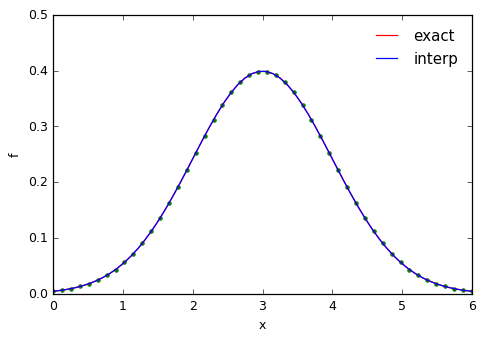

In [18]:
mu = 3.
sig2 = 1.

# Gaussian function
def fg(x):    
    return np.exp(-(x-mu)**2/sig2/2.)/np.sqrt(2.*np.pi*sig2)

# derivative of Gaussian function
def dfg(x):   
    return (mu-x)/sig2*fg(x)

xx = np.linspace(0,6,48)
yy = fg(xx)
yint = interpolate.interp1d(xx, yy, kind='cubic')

plt.xlabel('x')
plt.ylabel('f')
plt.xlim(0, 6)
plt.ylim(0, 0.5)
plt.plot(xx, yy, 'g.')
xlin = np.linspace(0,6,60)
plt.plot(xlin, fg(xlin), 'r-', label='exact')
plt.plot(xlin, yint(xlin), 'b-', label='interp')
plt.legend(frameon=False)

Now we write two routines to calculate the derivative $df/dx$ for a given value of $h$, the simple one-sided one and the better symmetric one, and output the result for a sequence of $h = 10^{-15}, 10^{-14}, ..., 10^{0}$.

exact answer = 0.241970724519
log steps = [-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
ratio of one-sided = [ 0.9176507   1.03235704  1.00023926  1.00023926  0.99999838  0.99999953
  1.0000001   1.          1.          1.          1.          1.
  0.99999967  0.99996658  0.99658855]
ratio of symmetric = [ 0.97500387  1.01515109  0.99966573  1.00018191  0.99999265  0.99999953
  1.0000001   0.99999999  1.          1.          1.          1.
  0.99999967  0.99996667  0.99667166]


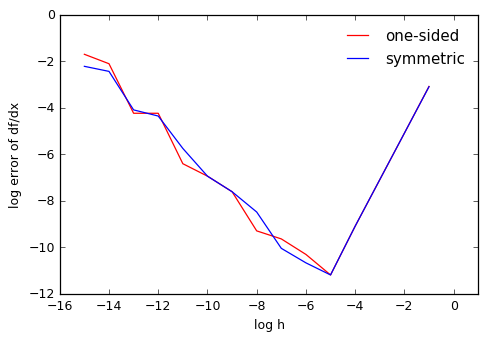

In [19]:
def diff1(f,x,h):
    return (f(x+h)-f(x))/h

def diff2(f,x,h):
    return (f(x+h)-f(x-h))/(2.*h)

x = 2.
loghh = np.arange(-15.,0.)
d1 = [diff1(fg, x, 10.**logh) for logh in loghh] #inline loop
d2 = [diff2(fg, x, 10.**logh) for logh in loghh]
de = dfg(x)
print "exact answer =",de
print "log steps =",loghh
print "ratio of one-sided =",d1/de
print "ratio of symmetric =",d2/de

plt.xlabel('log h')
plt.ylabel('log error of df/dx')
plt.xlim(-16, 1)
plt.ylim(-12, 0)
plt.plot(loghh, np.log10(np.fabs(d1-de)), 'r-', label='one-sided')
plt.plot(loghh, np.log10(np.fabs(d2-de)), 'b-', label='symmetric')
plt.legend(frameon=False)

Let's estimate the optimum value of $h$ in the case of symmetric deriative.  The value of the function $f$ and its characteristic scale $x_c$ are both of order unity.  Therefore, $h \sim \epsilon_f^{1/3} \sim 10^{-5}$, for machine accuracy of $\epsilon_f \sim 10^{-15}$.  The plot above confirms that this value corresponds to minimum error of the derivative.

Now let's use the linearly interpolated function.  Now the accuracy of the function calculation is lower.

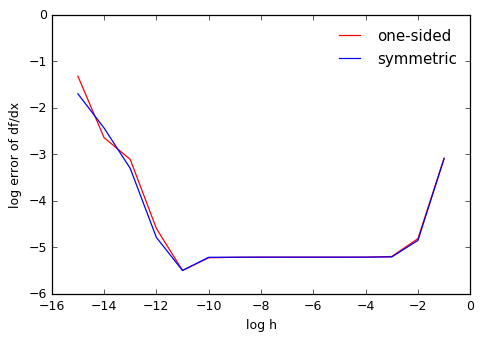

In [20]:
di1 = [diff1(yint, x, 10.**logh) for logh in loghh]
di2 = [diff2(yint, x, 10.**logh) for logh in loghh]

plt.xlabel('log h')
plt.ylabel('log error of df/dx')
plt.ylim(-6, 0)
plt.plot(loghh, np.log10(np.fabs(di1-de)), 'r-', label='one-sided')
plt.plot(loghh, np.log10(np.fabs(di2-de)), 'b-', label='symmetric')
plt.legend(frameon=False)

The best way to obtain an accurate solution is to use "Richardson's deferred approach to the limit", or "Richardson's method" for short.  The idea is to calculate a progression of $f'_i(x)$ at several decreasing values of $h_i$, starting with a fairly large value $h \sim 0.1 x_c$, and then extrapolate the result to $h \rightarrow 0$.  The extrapolation is done as an extension of an interpolating function going through the values $f'_i$.  The error of $f'$ is estimated from the last difference of the approximations.  We continue iterating until we reach required accuracy.

Consult $\S$[5.7](https://umich.instructure.com/files/2392548/download?download_frd=1) in <i>Numerical Recipes</i> for an efficient implementation of this method.

### Homework 1 (due Tuesday, Sep 20, 9am)

Write your own implementation of Richardson's method as a function that takes two arguments: the name of a user-defined function and the point at which to differentiate it. Calculate the same derivative $dP/dk$ as in Exercise 3.  Make a plot to compare your results with those from Exercise 3.

Please submit your homework as an IPython notebook like this.